<a href="https://colab.research.google.com/gist/benman1/2fa56a85ed92402d6ab2124b16590ad1/timeseries_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series Analysis**

 A time series data is a collection of observations x(t), where each data point is recorded at time t. The time can be discrete, t = 1,2,3,..., or
continuous t > 0.

There can be mainly four objectives of time series analysis 
* Exploratory
  - finding the relationship among variables
  - understanding seasonal effects
* Signal extraction
  - Noise removal
* Prediction
  - predict future values based on the previous values
* Data compression
  - compress the data for signal delivery or better understanding

In this recipe we will perform the following objectives
*   Generate some time series data and analyze it using pytorch LSTM framework
* Use Prophet by Facebook on real data


We will perform various traditional and modern methods to understand and analyse the forecasting of time series data. We wil analyze the weather data for this purpose from openml.

As usual we will load the data and perform various preprocessing. 

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [2]:
pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /Users/ben/anaconda3/lib/python3.6/site-packages (0.12.0)
Note: you may need to restart the kernel to use updated packages.


In [3]:
data = fetch_openml(data_id=41187)
data

{'data': array([[1958.,    3.,   29.,    4.,    0.,    0.],
        [1958.,    4.,    5.,    6.,    0.,    0.],
        [1958.,    4.,   12.,    4.,    0.,    0.],
        ...,
        [2001.,   12.,   15.,    7.,    0.,    0.],
        [2001.,   12.,   22.,    6.,    0.,    0.],
        [2001.,   12.,   29.,    6.,    0.,    0.]]),
 'target': array([316.1, 317.3, 317.6, ..., 371.2, 371.3, 371.5]),
 'frame': None,
 'categories': {'station': ['MLO']},
 'feature_names': ['year', 'month', 'day', 'weight', 'flag', 'station'],
 'target_names': ['co2'],
 'DESCR': '**Weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A.**<br><br>\nThese weekly averages are ultimately based on measurements of 4 air samples per hour taken atop intake lines on several towers during steady periods of CO2 concentration of not less than 6 hours per day; if no such periods are available on a given day, then no data are used for that day. The _W

We will use the scikit example  load_mauna_loa_atmospheric_co2 function for this purpose.
(https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) 

This data is one of the earliest recordings available on atmospheric recordings of Co2. As it will be later observed, this data follows a sinusoidal pattern with the Co2 concentration rising in winters and falling in the summers owing to the falling of the plant and vegetation in the winter season. This has started happening quite quickly these days.

This will spit out the average CO2 concentration measured at Mauna Loa Observatory in Hawaii from 1958 to 2001. We will try to model the CO2 concentration with respect to t.

In [4]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []
 
    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target
 
    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1
 
    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs
X, y = load_mauna_loa_atmospheric_co2()


In [5]:
df_CO2 = pd.DataFrame(data=X, columns = ['Year'])
df_CO2['CO2 in ppm'] = y

Text(0.5, 0.98, 'CO2 conc. mauna_loa 1958-2001')

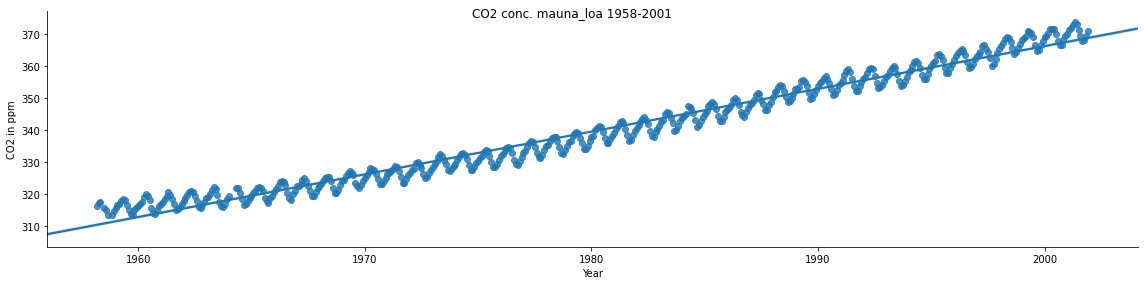

In [6]:
lm = sns.lmplot(x='Year', y='CO2 in ppm', data=df_CO2, height=4, aspect=4)
fig = lm.fig 
fig.suptitle("CO2 conc. mauna_loa 1958-2001", fontsize=12)

# We will take up the following models and show their usage step by step
  * Autoregressive Integrated Moving Average (ARIMA) model
  * Seasonal Autoregressive Integrated Moving-Average (SARIMA) model



In [36]:
# ARIMA model
# Autoregression of the time series data

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

In [37]:
import statsmodels.api as stm
d = stm.datasets.co2.load_pandas()
co2 = d.data
co2.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [38]:
co2['co2'] = co2['co2'].fillna(y.interpolate())
co2['co2'].isnull().sum()
# Handle missing values in the data
#co2['co2'] = co2['co2'].resample('MS').mean()

0

In [39]:
train_df = co2['1958':'1997']
test_df = co2['1998':'2001']
train_df = train_df.reset_index().rename(columns={'index': 'ds'})
test_df = test_df.reset_index().rename(columns={'index': 'ds'})
train_df.head()

,ds,co2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


In [40]:
df_CO2_fb = co2.reset_index()
df_CO2_fb.columns = ['ds', 'y']
df_CO2_fb['ds'] = df_CO2_fb['ds'].apply(pd.to_datetime)
df_CO2_fb = df_CO2_fb.set_index('ds')

df_CO2_fb.head()

,y
ds,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [41]:
#prediction_size = 52
#train_df = df_CO2_fb[:-prediction_size]

train_df = df_CO2_fb['1958':'1997']
test_df = df_CO2_fb['1998':'2001']
train_df = train_df.reset_index()
test_df = test_df.reset_index()
test_df.head()

,ds,y
0,1998-01-03,365.2
1,1998-01-10,365.3
2,1998-01-17,365.3
3,1998-01-24,365.3
4,1998-01-31,365.6


In [43]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def get_arima_model(history, order=(5, 1, 0)):
    return ARIMA(history, order=order)

def get_sarima_model(
    history,
    order=(5, 1, 1),
    seasonal_order=(0, 1, 1, 4)
    ):
    return SARIMAX(
        history,
        order=order,
        enforce_stationarity=True,
        enforce_invertibility=False,
        seasonal_order=seasonal_order
    )


def apply_model(train, test, model_fun=get_arima_model):
  '''we just roll with the model and apply it to successive
  time steps
  '''
  history = list(train)
  predictions = list()
  for t in test:
    model = model_fun(history).fit(disp=0)
    output = model.forecast()
    predictions.append(output[0])
    history.append(t)
  error = mean_squared_error(test, predictions)
  print('Test MSE: %.3f' % error)
  #print(model.summary().tables[1])
  return predictions, error

predictions_arima, error_arima = apply_model(
    train_df['y'].values, test_df['y'].values
)
predictions_sarima, error_sarima = apply_model(
    train_df['y'].values, test_df['y'].values
)

/Users/ben/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Test MSE: 0.215


/Users/ben/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Test MSE: 0.215


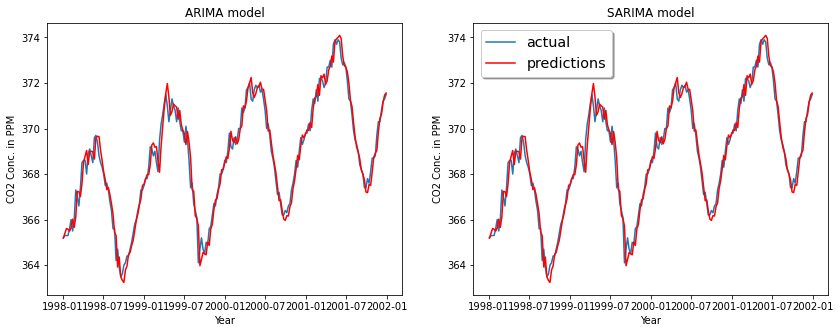

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(test_df['ds'], test_df['y'].values, label='actual')
ax1.plot(test_df['ds'], predictions_arima, color='red', label='Arima predictions')
ax1.set_title('ARIMA model')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 Conc. in PPM')

ax2.plot(test_df['ds'], test_df['y'].values, label='actual')
ax2.plot(test_df['ds'], predictions_arima, color='red', label='predictions')
ax2.legend(loc='upper left', shadow=True, fontsize='x-large')
ax2.set_title('SARIMA model')
ax2.set_xlabel('Year')
ax2.set_ylabel('CO2 Conc. in PPM')
plt.show()

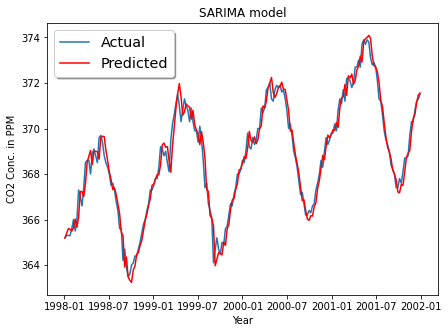

In [51]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(test_df.ds, test_df.y, label='Actual')
ax.plot(test_df.ds, predictions_sarima, color='red', label='Predicted')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title('SARIMA model')
plt.xlabel('Year')
plt.ylabel('CO2 Conc. in PPM')

plt.show()

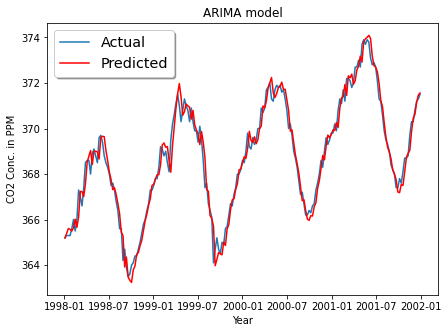

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(test_df.ds, test_df.y, label='Actual')
ax.plot(test_df.ds, predictions_arima, color='red', label='Predicted')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title('ARIMA model')
plt.xlabel('Year')
plt.ylabel('CO2 Conc. in PPM')

plt.show()

**Decomposition of signal using the statsmodel method**

statsmodels provides a method to perform the decomposition of the signal based on seasonality of the data. Detailed mathematical analysis can be found at , “[STL: A Seasonal-Trend Decomposition Procedure Based on Loess.](http://www.wessa.net/download/stl.pdf)”

The script here shows the time-series seasonal decomposition of the Co2 data showing a clear seasonal variation in the Co2 concentration whuch can be taraced back to the biology.

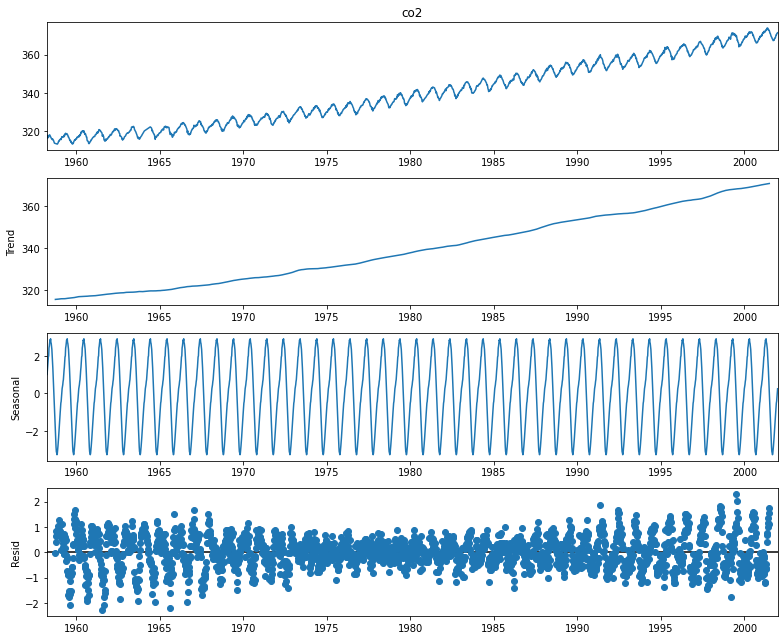

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

result = stm.tsa.seasonal_decompose(co2['co2'], model='additive')
pd.plotting.register_matplotlib_converters()
result.plot()
plt.show()

In [57]:
len(predictions_arima)

209


**Prophet**

Prophet is a a library provided by Facebook for forecasting time series data. It works on  an additive model and fits non-linear models. The library works best when the data has strong seasonal effects and has enough historic trend available.

 Details can be found at
 
 https://facebook.github.io/prophet/




In [58]:
!pip install fbprophet

     |████████████████████████████████| 64 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 37.4 MB 30.3 MB/s eta 0:00:01    |█████████▌                      | 11.1 MB 8.1 MB/s eta 0:00:04MB/s eta 0:00:03
     |████████████████████████████████| 40 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 114 kB 11.0 MB/s eta 0:00:01
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
     |████████████████████████████████| 1.5 MB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 732 kB 13.6 MB/s eta 0:00:01     |█████████▉                      | 225 kB 13.6 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Users/ben/anaconda3/bin/python3.6 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pip-install-ga0zo1id/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pip-install-ga0zo1id/fbprophet/setup.py

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.7.5
    Uninstalling python-dateutil-2.7.5:
      Successfully uninstalled python-dateutil-2.7.5
    Running setup.py install for fbprophet ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

boto3 1.9.70 requires botocore<1.13.0,>=1.12.70, but you'll have botocore 1.17.51 which is incompatible.


In [59]:
from fbprophet import Prophet

Text(0.5, 1.0, 'Weekely Co2 in ppm')

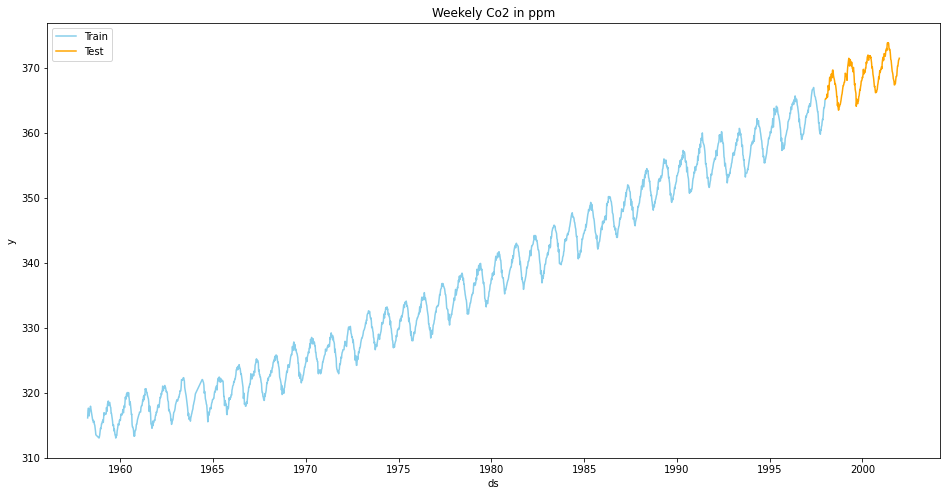

In [60]:
import seaborn as sns
plt.figure(figsize=(16, 8))
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df, label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df, ax=ax)
plt.title('Weekely Co2 in ppm')

In [61]:
train_df['mean_baseline'] = train_df['y'].mean()
test_df['mean_baseline']  = test_df['y'].mean()
print('Average Co2 conc (ppm) in the train set:', train_df['y'].mean())

Average Co2 conc (ppm) in the train set: 336.72077108433706


In [62]:
train_df['naive_baseline'] = train_df['y'].shift(1).bfill()
train_last_observation = train_df['naive_baseline'].iloc[-1]
test_df['naive_baseline'] = train_last_observation

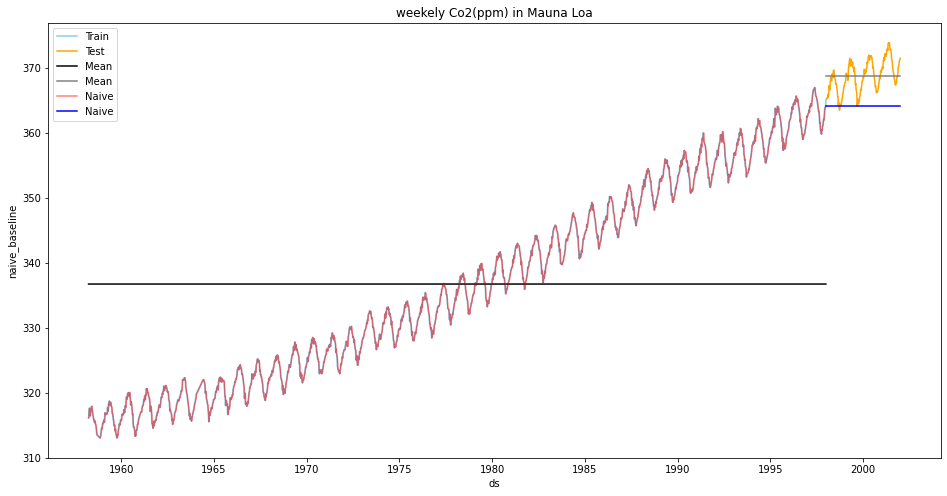

In [63]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df, label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df, ax=ax)
sns.lineplot(x='ds', y='mean_baseline', color='black', data=train_df, label='Mean', ax=ax)
sns.lineplot(x='ds', y='mean_baseline', color='gray', data=test_df, label='Mean',ax=ax)
sns.lineplot(x='ds', y='naive_baseline', color='red', alpha=.5, data=train_df, label='Naive', ax=ax)
sns.lineplot(x='ds', y='naive_baseline', color='blue', data=test_df, label='Naive',ax=ax)

plt.title('weekely Co2(ppm) in Mauna Loa');

In [64]:
from sklearn.metrics import mean_squared_error
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
train_mse = mean_squared_error(train_df['y'], train_df['mean_baseline'])
test_mse = mean_squared_error(test_df['y'], test_df['mean_baseline'])
print('Train MSE, for mean baseline:', train_mse)
print('Test MSE, for mean baseline:', test_mse)

Train MSE, for mean baseline: 227.32899162882546
Test MSE, for mean baseline: 5.9395421350243796


In [65]:
train_mse = mean_squared_error(train_df['y'], train_df['naive_baseline'])
test_mse = mean_squared_error(test_df['y'], test_df['naive_baseline'])
print('Train MAE, for naive baseline:', train_mse)
print('Test MAE, for naive baseline:', test_mse)

Train MAE, for naive baseline: 0.2369673162826746
Test MAE, for naive baseline: 26.727033492823075


In [66]:
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

In [67]:
train_df = train_df.rename(columns={'index': 'ds'})
test_df = test_df.rename(columns={'index': 'ds'})

In [68]:
Co2_model= Prophet(interval_width=0.1, seasonality_mode='multiplicative', weekly_seasonality=False)

Co2_model.fit(train_df)
train_forecast = Co2_model.predict(train_df[['ds', 'y']])
test_forecast = Co2_model.predict(test_df[['ds', 'y']])

INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
train_mse = mean_squared_error(train_df['y'], train_forecast['yhat'])
test_mse = mean_squared_error(test_df['y'], test_forecast['yhat'])
print('Train MSE for Prophet:', train_mse)
print('Test MSE for Prophet:', test_mse)

Train MSE for Prophet: 0.193987274656432
Test MSE for Prophet: 3.4432226389990754


Text(0.5, 1.0, 'CO2 conc(PPM) in Mauna Loa')

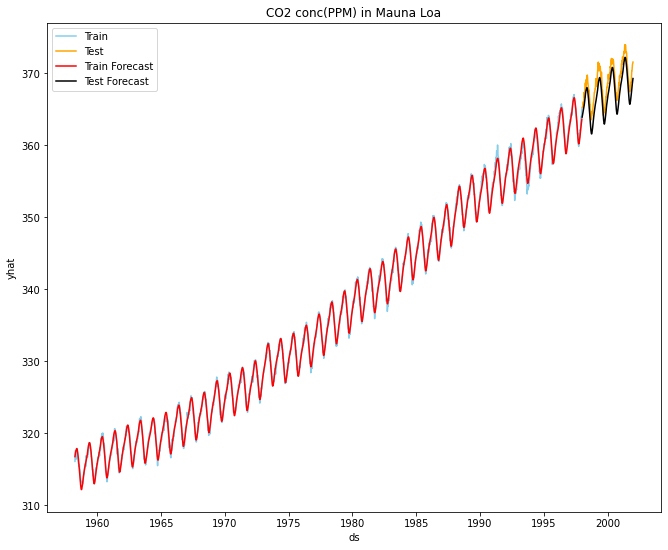

In [70]:
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df[['ds', 'y']], label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df[['ds', 'y']], ax=ax)
sns.lineplot(x='ds', y='yhat', color='red', label='Train Forecast', data=train_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', color='black', label='Test Forecast', data=test_forecast, ax=ax)

plt.title('CO2 conc(PPM) in Mauna Loa')

In [71]:
fut = Co2_model.make_future_dataframe(periods=12, freq='M')
forecast_df = Co2_model.predict(fut)


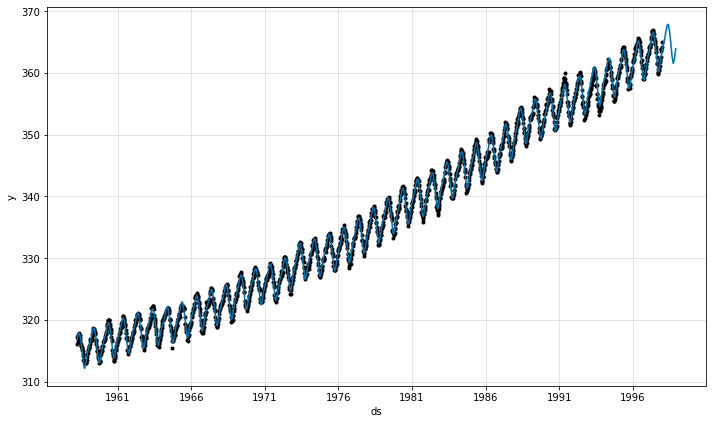

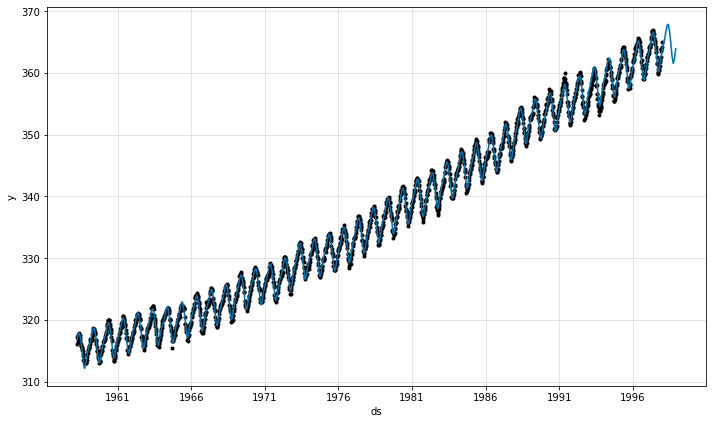

In [72]:
Co2_model.plot(forecast_df)

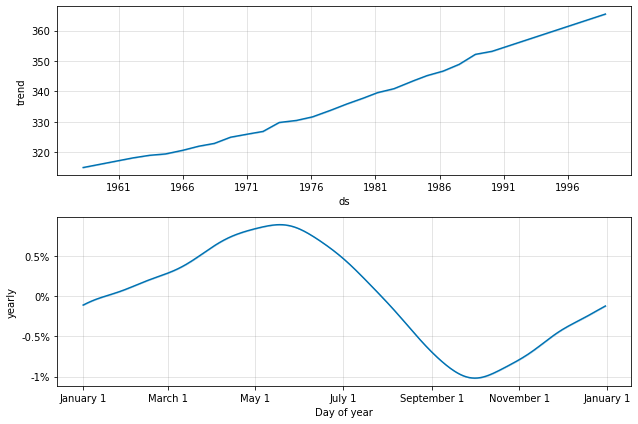

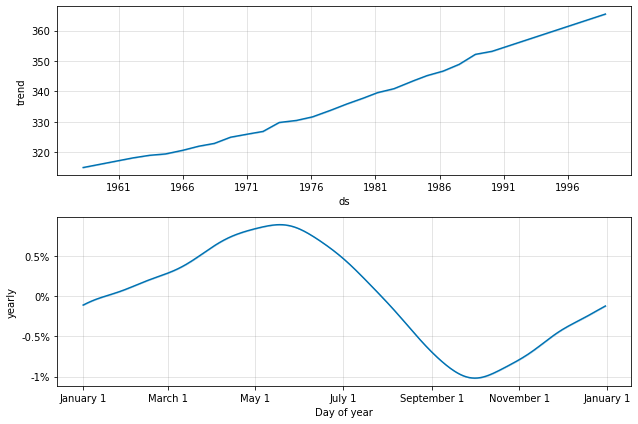

In [73]:
Co2_model.plot_components(forecast_df)

In [74]:
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2082,1998-07-31,365.003795,364.741072,364.840277,365.003795,365.003795,-0.000573,-0.000573,-0.000573,-0.000573,-0.000573,-0.000573,0.0,0.0,0.0,364.794512
2083,1998-08-31,365.121628,362.567744,362.684755,365.121628,365.121628,-0.006722,-0.006722,-0.006722,-0.006722,-0.006722,-0.006722,0.0,0.0,0.0,362.667349
2084,1998-09-30,365.235659,361.485812,361.606431,365.235659,365.235659,-0.010172,-0.010172,-0.010172,-0.010172,-0.010172,-0.010172,0.0,0.0,0.0,361.520464
2085,1998-10-31,365.353491,362.343376,362.480553,365.353491,365.353491,-0.008013,-0.008013,-0.008013,-0.008013,-0.008013,-0.008013,0.0,0.0,0.0,362.425768
2086,1998-11-30,365.467522,363.868973,363.983608,365.467522,365.467522,-0.004294,-0.004294,-0.004294,-0.004294,-0.004294,-0.004294,0.0,0.0,0.0,363.898057
